In [1]:
import yfinance
import numpy as np
import pandas as pd
import pandas
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

import cufflinks as cf
cf.set_config_file(offline=True)

import warnings
warnings.filterwarnings("ignore")


In [2]:
from ActMng import AccountManager

In [3]:
starting_capital = 100000
allocation = 0.8

symbol = 'NFLX'

long_trend_days = 12
short_trend_days = 6

In [4]:
def fetch_data(symbol:str='NFLX', start_date:str='2020', end_date:str=None):
    
    if end_date is None:
        end = pandas.Timestamp.now()
    else:
        end = end_date
    
    return pdr.get_data_yahoo(symbol, pandas.Timestamp(start_date), pandas.Timestamp(end))[['Open','Close']]
df = fetch_data(symbol)

[*********************100%***********************]  1 of 1 completed


In [5]:
fast_trend = df.Open.rolling(window=short_trend_days).mean()
slow_trend = df.Open.rolling(window=long_trend_days).mean()

df['ma_fast'] = fast_trend
df['ma_slow'] = slow_trend
df[['Close','ma_fast','ma_slow']].iplot()

In [7]:
df['trade_direction'] = np.sign(fast_trend-slow_trend)
df

,Open,Close,ma_fast,ma_slow,trade_direction
Date,,,,,
2019-12-31,322.000000,323.570007,NaN,NaN,NaN
2020-01-02,326.100006,329.809998,NaN,NaN,NaN
2020-01-03,326.779999,325.899994,NaN,NaN,NaN
2020-01-06,323.119995,335.829987,NaN,NaN,NaN
2020-01-07,336.470001,330.750000,NaN,NaN,NaN
...,...,...,...,...,...
2021-11-08,650.289978,651.450012,674.931661,670.992498,1.0
2021-11-09,653.700012,655.989990,669.038330,671.149999,-1.0
2021-11-10,653.010010,646.909973,664.021667,670.255834,-1.0


In [8]:
#Determine the direction of the moving average differences
df_trades = df['trade_direction'].dropna().diff().dropna().apply(np.sign).astype('int8')
df_trades = pandas.DataFrame(df_trades[df_trades !=0])

#Label our intended trades
df_trades['trade'] = df['trade_direction'].map({1:'Long',-1:'Short'})
df['trades'] = df_trades['trade']

In [9]:
#Label our opening trade after removing our window period
df['trades'].replace(pandas.np.NaN,'None',inplace=True)
df = df.dropna()
df['trades'].iloc[0]=('Long' if df['trade_direction'].iloc[0]==1.0 else 'Short')
df

,Open,Close,ma_fast,ma_slow,trade_direction,trades
Date,,,,,,
2020-01-16,343.500000,338.619995,339.584997,333.622498,1.0,Long
2020-01-17,341.000000,339.670013,339.418330,335.205831,1.0,None
2020-01-21,340.000000,338.109985,339.896662,336.364164,1.0,None
2020-01-22,332.549988,326.000000,340.021662,336.844996,1.0,None
2020-01-23,326.040009,349.600006,336.961665,337.088331,-1.0,Short
...,...,...,...,...,...,...
2021-11-08,650.289978,651.450012,674.931661,670.992498,1.0,None
2021-11-09,653.700012,655.989990,669.038330,671.149999,-1.0,Short
2021-11-10,653.010010,646.909973,664.021667,670.255834,-1.0,None


In [10]:
# Our trading strategy implementation - feel free to brose ActMng.py if you are curious.
trading_strategy = AccountManager(symbol=symbol,trades_df=df,starting_capital=starting_capital,allocation_amount=allocation)
results = trading_strategy.run()

In [11]:
#Here we can see a day by day breakdown of the account
results['result_df']

,Open,Close,ma_fast,ma_slow,trade_direction,trades,account_val,cash_bal,position,position_changes,fees
2020-01-16,343.500000,338.619995,339.584997,333.622498,1.0,Long,98862.446863,19997.850000,232.90,232.90,1.0
2020-01-17,341.000000,339.670013,339.418330,335.205831,1.0,None,99106.996127,19997.850000,232.90,0.00,0.0
2020-01-21,340.000000,338.109985,339.896662,336.364164,1.0,None,98743.665588,19997.850000,232.90,0.00,0.0
2020-01-22,332.549988,326.000000,340.021662,336.844996,1.0,None,95923.250000,19997.850000,232.90,0.00,0.0
2020-01-23,326.040009,349.600006,336.961665,337.088331,-1.0,Short,90384.780165,172677.125602,-235.39,-468.29,2.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-11-08,650.289978,651.450012,674.931661,670.992498,1.0,None,78754.891764,15759.675584,96.70,0.00,0.0
2021-11-09,653.700012,655.989990,669.038330,671.149999,-1.0,Short,78749.140388,142150.572944,-96.65,-193.35,2.0
2021-11-10,653.010010,646.909973,664.021667,670.255834,-1.0,None,79626.724040,142150.572944,-96.65,0.00,0.0
2021-11-11,650.239990,657.580017,659.516663,668.295832,-1.0,None,78595.464292,142150.572944,-96.65,0.00,0.0


In [12]:
# Here are our simulated orders as we would submit to an API endpoint for algorthmic trading. 
results['broker_orders']

,symbol,date,time,order,order_type,price,size,exchange_fees
2020-01-16,NFLX,2020-01-16 00:00:00,At Market Open,BUY,MARKET,343.500000,232.90,1.0
2020-01-23,NFLX,2020-01-23 00:00:00,At Market Open,SELL,MARKET,326.040009,232.90,1.0
2020-01-23,NFLX,2020-01-23 00:00:00,At Market Open,SELL,MARKET,326.040009,235.39,1.0
2020-01-24,NFLX,2020-01-24 00:00:00,At Market Open,BUY,MARKET,348.459991,235.39,1.0
2020-01-24,NFLX,2020-01-24 00:00:00,At Market Open,BUY,MARKET,348.459991,208.12,1.0
...,...,...,...,...,...,...,...,...
2021-10-22,NFLX,2021-10-22 00:00:00,At Market Open,BUY,MARKET,651.809998,103.24,1.0
2021-10-22,NFLX,2021-10-22 00:00:00,At Market Open,BUY,MARKET,651.809998,96.70,1.0
2021-11-09,NFLX,2021-11-09 00:00:00,At Market Open,SELL,MARKET,653.700012,96.70,1.0
2021-11-09,NFLX,2021-11-09 00:00:00,At Market Open,SELL,MARKET,653.700012,96.65,1.0


<AxesSubplot:>

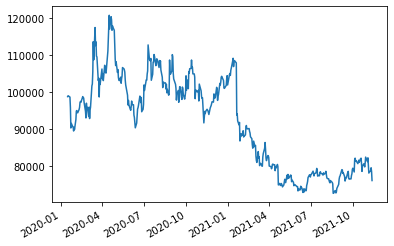

In [16]:
#Todo:

r_df = results['result_df']

# Calculate the Absolute Return of our trend-following trading strategy
absolute_return_tf = (r_df['account_val'].iloc[-1]-starting_capital)/starting_capital

# Calculate the CAGR or our trend-following trading strategy
CAGR_tf = ((r_df['account_val'].iloc[-1]/starting_capital)**(252/len(df)))-1
#or
CAGR_tf = ((r_df['account_val'].iloc[-1]/starting_capital)**(365/(df.index[-1] - df.index[0]).days))-1


# Calculate the IR (Sharpe without RF-rate) of our trend-following trading strategy
information_ratio_tf = (r_df.account_val.pct_change().mean()/r_df.account_val.pct_change().std())*((252) **0.5)

#Plot the equity curve (hint: use 'account_val')
r_df.account_val.iplot()
#or
r_df.account_val.plot()


<AxesSubplot:>

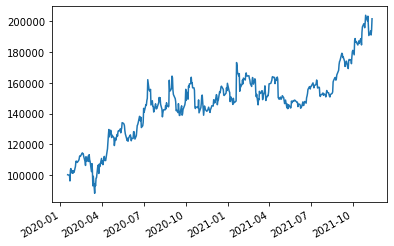

In [17]:
#Todo:
# Calculate the Absolute Return of a buy-and-hold strategy in the same period
absolute_return_bh = (r_df.Close.iloc[-1]-r_df.Open.iloc[0])/r_df.Open.iloc[0]
# Calculate the CAGR or a buy-and-hold trading strategy
CAGR_bh = ((r_df.Close.iloc[-1]/r_df.Open.iloc[0])**(252/len(df)))-1
#or
CAGR_bh = ((r_df.Close.iloc[-1]/r_df.Open.iloc[0])**(365/(df.index[-1] - df.index[0]).days))-1

# Calculate the IR (Sharpe without RF-rate) of a buy-and-hold trading strategy
information_ratio_bh = (r_df.Close.pct_change().mean()/r_df.Close.pct_change().std())*((252) **0.5)

#Plot the equity curve (hint: use 'close' returns and your initial capital value to generate an equity curve)
((r_df.Close.pct_change().dropna()+1).cumprod()*starting_capital).iplot()
#or
((r_df.Close.pct_change().dropna()+1).cumprod()*starting_capital).plot()


In [14]:
#Todo - optional, below:
# Copy any of the code from above to new cells below, and see how changing the symbol, dates and trend parameters changes the performance
# Can you beat the reference implementation?